In [1]:
%autosave 0

Autosave disabled


In [2]:
import pandas as pd
import numpy as np
print(pd.__version__)
print(np.__version__)

1.3.2
1.20.3


## data ingestion

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'

In [4]:
!wget $data

--2021-09-18 17:45:28--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv.1’

AB_NYC_2019.csv.1   100%[===================>]   6.75M  2.64MB/s    in 2.6s    

2021-09-18 17:45:31 (2.64 MB/s) - ‘AB_NYC_2019.csv.1’ saved [7077973/7077973]



In [5]:
df = pd.read_csv('AB_NYC_2019.csv', delimiter = ',')

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<AxesSubplot:xlabel='price', ylabel='Count'>

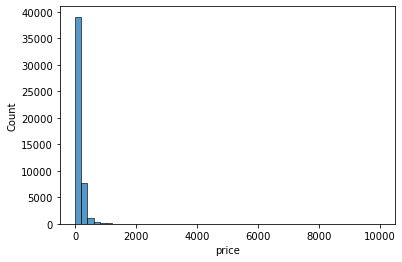

In [7]:
sns.histplot(df.price, bins=50)

<AxesSubplot:xlabel='price', ylabel='Count'>

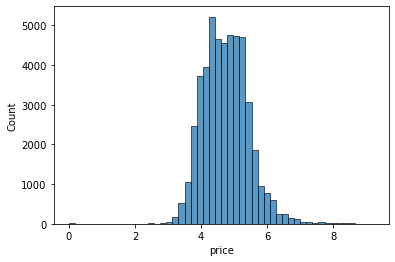

In [8]:
sns.histplot(np.log1p(df.price), bins=50)

## feature engineering

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [10]:
df = df[[
    'latitude', 
    'longitude', 
    'price', 
    'minimum_nights', 
    'number_of_reviews', 
    'reviews_per_month', 
    'calculated_host_listings_count', 
    'availability_365'
]]

## question 1

In [11]:
df.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [12]:
df.reviews_per_month.isnull().sum()

10052

## question 2

In [13]:
df.minimum_nights.describe().round(2)

count    48895.00
mean         7.03
std         20.51
min          1.00
25%          1.00
50%          3.00
75%          5.00
max       1250.00
Name: minimum_nights, dtype: float64

In [14]:
df.minimum_nights.median()

3.0

## splitting the data

In [15]:
n = len(df)
print("Dataset length: {}".format(n))

Dataset length: 48895


In [16]:
np.random.seed(42)

idx = np.arange(n)
np.random.shuffle(idx)
df = df.iloc[idx[:]]
df = df.reset_index(drop=True)

In [17]:
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = (n - n_val - n_test)

print(n_val, n_test, n_train)

9779 9779 29337


In [18]:
n == n_train + n_val + n_test

True

In [19]:
y = np.log1p(df.price)

In [20]:
del df['price']

In [21]:
df_train = df.iloc[:n_train]
df_val = df.iloc[n_train:(n_train + n_val)]
df_test = df.iloc[(n_train + n_val):]

len(df_train), len(df_val), len(df_test)

(29337, 9779, 9779)

In [22]:
y_train = y.iloc[:n_train]
y_val = y.iloc[n_train:(n_train + n_val)]
y_test = y.iloc[(n_train + n_val):]

len(y_train), len(y_val), len(y_test)

(29337, 9779, 9779)

## question 3

In [23]:
df_train.reviews_per_month.isnull().sum()

5998

In [24]:
df_train.reviews_per_month.describe()

count    23339.000000
mean         1.368549
std          1.653934
min          0.010000
25%          0.190000
50%          0.710000
75%          2.030000
max         27.950000
Name: reviews_per_month, dtype: float64

In [25]:
NaN_mean = df_train.reviews_per_month.mean()
NaN_mean

1.3685492094777056

In [26]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [27]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    
    return np.sqrt(mse)

In [28]:
df_train.columns

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [29]:
base = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365']

X_train = df_train[base].fillna(0).values
w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)

In [30]:
w0

-419.91265863459563

In [31]:
w

array([ 1.30676225e+00, -5.02167855e+00, -5.59803110e-04, -4.07634896e-04,
       -8.25470066e-03,  1.33371320e-03,  6.50203890e-04])

In [32]:
round(rmse(y_train, y_pred), 2)

0.64

In [33]:
X_train2 = df_train[base].fillna(NaN_mean).values
w0, w = train_linear_regression(X_train2, y_train)

y_pred2 = w0 + X_train2.dot(w)

In [34]:
w0

-423.539308195656

In [35]:
w

array([ 1.31148321e+00, -5.06799071e+00, -4.87741552e-04, -6.63849280e-04,
        5.34563274e-03,  1.32706019e-03,  6.38794182e-04])

In [36]:
round(rmse(y_train, y_pred2), 2)

0.64

## question 4

In [37]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [38]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

round(rmse(y_val, y_pred), 2)

0.64

In [39]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [40]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = round(rmse(y_val, y_pred), 2)    
    
    print(r, w0, score)

0 -419.91265863459563 0.64
1e-06 -419.86271586621507 0.64
0.0001 -414.97649263761593 0.64
0.001 -375.27365275360376 0.64
0.01 -191.78384053419808 0.66
0.1 -32.56256054996282 0.68
1 -3.4992168360569 0.68
5 -0.7033623167239721 0.68
10 -0.35127675889492427 0.68


## question 5

In [41]:
results = []

for seed_value in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    np.random.seed(seed_value)
    
    df = pd.read_csv('AB_NYC_2019.csv', delimiter = ',')
    df = df[[
    'latitude', 
    'longitude', 
    'price', 
    'minimum_nights', 
    'number_of_reviews', 
    'reviews_per_month', 
    'calculated_host_listings_count', 
    'availability_365']]
    
    idx = np.arange(len(df))
    np.random.shuffle(idx)
    df = df.iloc[idx[:]]
    df = df.reset_index(drop=True)

    df_train = df.iloc[:n_train]
    df_val = df.iloc[n_train:(n_train + n_val)]
    y_train = np.log1p(df_train.price)
    y_val = np.log1p(df_val.price)
    del df_train['price']
    del df_val['price']
   
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)
    
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    
    results.append(rmse(y_val, y_pred))
    
    print(seed_value, round(rmse(y_val, y_pred), 2))

0 0.65
1 0.65
2 0.65
3 0.64
4 0.64
5 0.63
6 0.63
7 0.65
8 0.65
9 0.64


In [42]:
round(np.std(results), 3)

0.008

## question 6

In [43]:
np.random.seed(9)

idx = np.arange(len(df))
np.random.shuffle(idx)
df = df.iloc[idx[:]]
df = df.reset_index(drop=True)

df_train = df.iloc[:n_train]
df_val = df.iloc[n_train:(n_train + n_val)]
df_test = df.iloc[(n_train + n_val):]

y_train = np.log1p(df_train.price)
y_val = np.log1p(df_val.price)
y_test = np.log1p(df_test.price)    
del df_train['price']
del df_val['price']
del df_test['price']

In [44]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

X_full_train = prepare_X(df_full_train)

In [45]:
y_full_train = np.concatenate([y_train, y_val])

w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

In [46]:
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)

score = rmse(y_test, y_pred)
round(score, 2)

0.65